In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.svm import LinearSVC

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import mixture, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.covariance import empirical_covariance


# import scipy
import json 
import random
import numpy as np
import itertools 
import sys
import os
import matplotlib as mpl
# from scipy import linalg

# import word embeddings models 
from transformers import BertTokenizer, BertModel
import torch

# Remove all the un-necessary warnings
# import warnings
# warnings.filterwarnings('ignore')
path = 'Data/CONAN-master/Multitarget-CONAN/'
file = 'Multitarget-CONAN.json'
file_p = path + file

In [91]:
# opens json file and loads json as dictionary 
# on Windows encoding is utf8 so make sure to specify 
with open(file_p, "r", encoding="utf8") as f:
     multi_target = json.load(f)

# multi_target = pd.DataFrame(multi_target)
# print(multi_target)

# for ind in multi_target: 
# #     print(ind)
#     for head in multi_target[ind]:
# #         print(" " + head)
#         # print out 4 types (Hate speech, counter narrative, target person, version) and string value 
# #         print("  " + multi_target[ind][head])
#         multi_target[ind][head]

# Turns json file/python dict format into pandas dataframe 
mt_df = pd.DataFrame(multi_target)
# print(mt_df)

# collects hate speech into dataframe and series 
hs_orig = mt_df.iloc[0, :] 
print(hs_orig)

# collects counter narrative into dataframe and series 
# cn_orig = mt_df.iloc[1, :] 
# print(cn_orig)

# collects target minority into dataframe and series 
min_tar_orig = mt_df.iloc[2, :] # pd.DataFrame(mt_df.iloc[2, :], columns = ["TARGET"])
# print(min_tar_orig)

labels = np.unique(min_tar_orig)
print(labels)

# collects version of dataset into dataframe and series 
# vers_orig = mt_df.iloc[3, :] 
# print(vers_orig)

f.close()

0       Maybe the UN could talk to those asian and afr...
1       ‘Juice (Jews) are worse that nukes.’ Caption t...
2       Foreigners on UK benefits leaps 41% in 5 years...
3       Jews cannot be patriots, since their allegianc...
4       Israel, Zionism and Jewish Supremacist control...
                              ...                        
4998                       Woman are basically childlike.
4999                   women should be submissive to men.
5000    Women are essentially childlike, unable to und...
5001                   Women should be submissive to men.
5002    Women should not be allowed to vote, this is a...
Name: HATE_SPEECH, Length: 5003, dtype: object
['DISABLED' 'JEWS' 'LGBT+' 'MIGRANTS' 'MUSLIMS' 'POC' 'WOMEN' 'other']


In [41]:
# transpose to make value feature and number of values x axis (columns) 
mt_df_T = mt_df.T 
mt_df_T.head()
# mt_df_T[mt_df_T.isnull().any(axis=1)] # remove null values from dataframe - unnecessary for this data 


,HATE_SPEECH,COUNTER_NARRATIVE,TARGET,VERSION
0,Maybe the UN could talk to those asian and afr...,"You're right, ocean pollution is one of the ma...",other,V1
1,‘Juice (Jews) are worse that nukes.’ Caption t...,You'd rather be nuked then?,JEWS,V1
2,Foreigners on UK benefits leaps 41% in 5 years...,You seem to be worried about government expend...,MIGRANTS,V1
3,"Jews cannot be patriots, since their allegianc...",You can have parents and grandparents born els...,JEWS,V1
4,"Israel, Zionism and Jewish Supremacist control...",Wouldn't you say its colonialism from many dif...,JEWS,V1


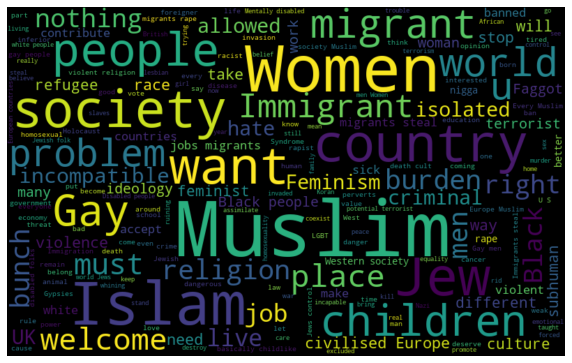

In [48]:
# visualizing which of the word is most commonly used in the twitter dataset
from wordcloud import WordCloud
# imshow-Display data as an image
# interpolation - https://matplotlib.org/3.2.1/gallery/images_contours_and_fields/interpolation_methods.html
all_words = ' '.join([text for text in mt_df_T['HATE_SPEECH'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
#random=0.30
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [50]:
# !pip install _ # use ! to call commandline commands 

# one hot encode target categories 
pd.get_dummies(min_tar_orig, columns=["TARGET"], prefix="target").head()
min_tar_dum = pd.get_dummies(min_tar_orig, columns=["TARGET"], prefix="target")
print(min_tar_dum)

      target_DISABLED  target_JEWS  target_LGBT+  target_MIGRANTS  \
0                   0            0             0                0   
1                   0            1             0                0   
2                   0            0             0                1   
3                   0            1             0                0   
4                   0            1             0                0   
...               ...          ...           ...              ...   
4998                0            0             0                0   
4999                0            0             0                0   
5000                0            0             0                0   
5001                0            0             0                0   
5002                0            0             0                0   

      target_MUSLIMS  target_POC  target_WOMEN  target_other  
0                  0           0             0             1  
1                  0           0             

In [65]:
min_tar = min_tar_orig.replace(labels, range(len(labels)))
print(min_tar)

#TF-IDF Features-F1
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
# max and min are cutoffs for document frequency 
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),
                                   max_df = 0.75, min_df=5, 
                                   max_features=10000)

# TF-IDF feature matrix
docs = tfidf_vectorizer.fit_transform(hs_orig)
display(docs)

0       7
1       1
2       3
3       1
4       1
       ..
4998    6
4999    6
5000    6
5001    6
5002    6
Name: TARGET, Length: 5003, dtype: int64


<5003x3602 sparse matrix of type '<class 'numpy.float64'>'
	with 91052 stored elements in Compressed Sparse Row format>

In [86]:
X = docs
y = min_tar
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
model = LogisticRegression().fit(X_train, y_train)
y_preds = model.predict(X_test)
report = classification_report(y_test, y_preds)
print(report)
acc = accuracy_score(y_test, y_preds)
mod_train = model.score(X_train, y_train) 

print('Logistic Regression Train accuracy {:.3f}%'.format(mod_train * 100)) 
print('Logistic Regression Test accuracy {:.3f}%'.format(acc * 100)) 

print('Confusion matrix: ')
print(confusion_matrix(y_test, y_preds)) 

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        46
           1       0.99      0.97      0.98       129
           2       0.96      0.96      0.96       120
           3       0.91      0.98      0.94       192
           4       0.91      0.98      0.95       265
           5       0.98      0.86      0.92        64
           6       0.93      0.98      0.95       126
           7       1.00      0.53      0.69        59

    accuracy                           0.94      1001
   macro avg       0.96      0.89      0.92      1001
weighted avg       0.94      0.94      0.94      1001

Logistic Regression Train accuracy 96.377%
Logistic Regression Test accuracy 93.906%
Confusion matrix: 
[[ 41   0   2   0   2   0   1   0]
 [  0 125   0   1   3   0   0   0]
 [  0   0 115   1   3   0   1   0]
 [  0   0   0 189   2   1   0   0]
 [  0   0   0   3 261   0   1   0]
 [  0   1   0   4   2  55   2   0]
 [  0   0   0   1   2   0 123   0]


In [90]:
print(pd.Series(y_test))
print(pd.Series(y_preds))

414     3
1815    0
642     7
1056    2
4507    0
       ..
1623    3
2005    1
4174    3
3467    7
3475    6
Name: TARGET, Length: 1001, dtype: int64
0       3
1       0
2       6
3       2
4       0
       ..
996     3
997     1
998     3
999     7
1000    6
Length: 1001, dtype: int64


In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_preds = rf.predict(X_test)
report = classification_report(y_test, y_preds)
acc1 = accuracy_score(y_test, y_preds)
mod_train1 = model.score(X_train, y_train) 

print(report)

print('Random Forest Train accuracy {:.3f}%'.format(mod_train1 * 100)) 
print('Random Forest Test accuracy {:.3f}%'.format(acc1 * 100)) 

print('Confusion matrix: ')
print(confusion_matrix(y_test, y_preds)) 

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        46
           1       1.00      0.96      0.98       129
           2       0.91      0.94      0.93       120
           3       0.90      0.97      0.94       192
           4       0.94      0.98      0.96       265
           5       0.90      0.89      0.90        64
           6       0.94      0.95      0.95       126
           7       0.97      0.59      0.74        59

    accuracy                           0.94      1001
   macro avg       0.95      0.90      0.92      1001
weighted avg       0.94      0.94      0.94      1001

Random Forest Train accuracy 96.377%
Random Forest Test accuracy 93.806%
Confusion matrix: 
[[ 43   0   2   0   1   0   0   0]
 [  0 124   1   1   3   0   0   0]
 [  0   0 113   2   0   0   4   1]
 [  0   0   1 187   2   2   0   0]
 [  0   0   0   3 260   2   0   0]
 [  0   0   1   4   1  57   1   0]
 [  0   0   3   2   1   0 120   0]
 [  0   0   

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), 
                                                    y, random_state=42, test_size=0.2)
nb = GaussianNB()
nb.fit(X_train, y_train)
y_preds = nb.predict(X_test)
report = classification_report(y_test, y_preds)
acc2 = accuracy_score(y_test, y_preds)
mod_train2 = model.score(X_train, y_train) 

print(report)

print('Naive Bayes Train accuracy {:.3f}%'.format(mod_train2 * 100)) 
print('Naive Bayes Test accuracy {:.3f}%'.format(acc2 * 100)) 

print('Confusion matrix: ')
print(confusion_matrix(y_test, y_preds)) 

              precision    recall  f1-score   support

           0       0.95      0.83      0.88        46
           1       0.88      0.81      0.85       129
           2       0.87      0.82      0.84       120
           3       0.80      0.76      0.78       192
           4       0.73      0.78      0.75       265
           5       0.70      0.58      0.63        64
           6       0.84      0.76      0.80       126
           7       0.39      0.64      0.49        59

    accuracy                           0.76      1001
   macro avg       0.77      0.75      0.75      1001
weighted avg       0.78      0.76      0.77      1001

Naive Bayes Train accuracy 96.377%
Naive Bayes Test accuracy 76.324%
Confusion matrix: 
[[ 38   0   2   2   2   1   1   0]
 [  0 105   2   4   8   2   3   5]
 [  1   0  98   2  14   1   3   1]
 [  0   2   1 145  19   5   1  19]
 [  0   5   2  16 207   2   4  29]
 [  0   3   2   5  11  37   4   2]
 [  1   3   4   4  12   3  96   3]
 [  0   1   2   

In [85]:
# display(y)
# display(pd.Series(y_preds))

In [69]:
t = BertTokenizer.from_pretrained("bert-base-cased")

model = BertModel.from_pretrained("bert-base-cased", 
                                  output_hidden_states = True,) 

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [70]:
hs_tok = [] # pd.DataFrame(dtype = 'object') 
hs_feat = [] # pd.DataFrame(dtype = 'object') 
target_word_embeddings = []
# Tweet 1 
embed1 = "Maybe the UN could talk to those asian and african nations responsible for 90%+ of the pollution in the oceans' instead of insisting on this bullshit about climate change."

ind = 0 
for doc in hs_orig: 
    # doc = "[CLS] " + doc + " [SEP]"
    t1 = t.tokenize(doc)
    ind_t1 = t.convert_tokens_to_ids(t1)
    seg_ids = [1]*len(ind_t1)
#     print(t1)
    hs_tok.append(t1) 
    
    # encode document text as quantitative features for training 
    t2 = t.encode(t1)
    #     print(t2)
    hs_feat.append(t2)
    
    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([ind_t1])
    segments_tensors = torch.tensor([seg_ids])
    # Model is in inference mode
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        # Removing the first hidden state
        # The first state is the input state
        hidden_states = outputs[2][1:]

    # Getting embeddings from the final BERT layer
    token_embeddings = hidden_states[-1]
    # Collapsing the tensor into 1-dimension
    token_embeddings = torch.squeeze(token_embeddings, dim=0)
    # Converting torchtensors to lists
    list_token_embeddings = [token_embed.tolist() for token_embed in token_embeddings]

# print(list_token_embeddings)
    # Find the position 'hate' in list of tokens
    # Get the embedding for hate
    if embed1 in hs_tok[ind]: 
        # print("len hs_tok[ind]:", len(hs_tok[ind]))
        word_index = (hs_tok[ind]).index(embed1)
        print("word_index:", word_index)
        # print("hs_tok[ind]:", hs_tok[ind]) 
        # print("list_token_embeddings:", list_token_embeddings)
        # print("len list_token_embeddings:", len(list_token_embeddings))
        # print("list_token_embeddings[word_index]:", list_token_embeddings[word_index])
        word_embedding = list_token_embeddings[word_index]
        target_word_embeddings.append(word_embedding)
    else:
        ind = ind 
        # target_word_embeddings.append(0.0)
        # target_word_embeddings.append("")

    ind += 1 

# print(hs_tok)
# print(hs_feat)
# print(pd.DataFrame(hs_feat))

In [43]:
from scipy.spatial.distance import cosine

# Calculating the distance between the
# embeddings of '' in all the
# given contexts of the word

list_of_distances = []
for text1, embed1 in zip(hs_orig, target_word_embeddings):
    for text2, embed2 in zip(hs_orig, target_word_embeddings):
        cos_dist = 1 - cosine(embed1, embed2)
        list_of_distances.append([text1, text2, cos_dist])

distances_df = pd.DataFrame(list_of_distances, columns=['text1', 'text2', 'distance'])
display(distances_df)

C:\Python37\lib\site-packages\scipy\spatial\distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


,text1,text2,distance
0,Maybe the UN could talk to those asian and afr...,Maybe the UN could talk to those asian and afr...,1
1,Maybe the UN could talk to those asian and afr...,‘Juice (Jews) are worse that nukes.’ Caption t...,1
2,Maybe the UN could talk to those asian and afr...,Foreigners on UK benefits leaps 41% in 5 years...,1
3,Maybe the UN could talk to those asian and afr...,"Jews cannot be patriots, since their allegianc...",1
4,Maybe the UN could talk to those asian and afr...,"Israel, Zionism and Jewish Supremacist control...",1
...,...,...,...
25030004,"Women should not be allowed to vote, this is a...",Woman are basically childlike.,1
25030005,"Women should not be allowed to vote, this is a...",women should be submissive to men.,1
25030006,"Women should not be allowed to vote, this is a...","Women are essentially childlike, unable to und...",1
25030007,"Women should not be allowed to vote, this is a...",Women should be submissive to men.,1


In [69]:
# test_df = mt_df_T
# test_df["TARGET"] = min_tar
# print(test_df)

# select K best of top 8 features probably 

# Likely candidates for feature reduction 
# mt_df['TARGET']=np.where(mt_df['TARGET'] =='POC', 'FOREIGNER', mt_df['TARGET'])
# mt_df['TARGET']=np.where(mt_df['TARGET'] =='MUSLIM', 'FOREIGNER', mt_df['TARGET'])
# mt_df['TARGET']=np.where(mt_df['TARGET'] =='MIGRANTS', 'FOREIGNER', mt_df['TARGET'])

      target_DISABLED  target_JEWS  target_LGBT+  target_MIGRANTS  \
0                   0            0             0                0   
1                   0            1             0                0   
2                   0            0             0                1   
3                   0            1             0                0   
4                   0            1             0                0   
...               ...          ...           ...              ...   
4998                0            0             0                0   
4999                0            0             0                0   
5000                0            0             0                0   
5001                0            0             0                0   
5002                0            0             0                0   

      target_MUSLIMS  target_POC  target_WOMEN  target_other  
0                  0           0             0             1  
1                  0           0             

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# test new Decision and RandomForest 
trees = DecisionTreeClassifier(random_state=0)
forest = RandomForestClassifier(n_estimators=15, random_state=2)
preds_trees = trees.fit(X_train,y_train).predict(X_test)
preds_forest = forest.fit(X_train,y_train).predict(X_test)
print('Trees Train accuracy %s' % model.score(X_train, y_train)) 
print('Forest Train accuracy %s' % model.score(X_train, y_train)) 

print('Trees Test accuracy %s' % accuracy_score(preds_trees, y_test)) 
print('Forest Test accuracy %s' % accuracy_score(preds_forest, y_test)) 